In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('../data/faceit_match_data.csv')

# Display the first 5 rows to make sure it loaded correctly
print("Data loaded successfully!")
df.head()

/home/sixtychris/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Data loaded successfully!


,match_id,player_id,nickname,map,player_kd_ratio,player_kr_ratio,kills,deaths,assists,headshots_percent,team_win,performed_well
0,1-34452cac-e8a3-479c-8b5e-959ead5678cb,cd156ccc-0a5c-4409-b441-f8b37cf0f8b2,ANIMAL_KABIS,de_mirage,2.00,1.17,28,14,5,32.0,1,1
1,1-34452cac-e8a3-479c-8b5e-959ead5678cb,b4afe644-b512-4e6f-acd5-df1116d53a8e,lynxAT,de_mirage,1.43,0.83,20,14,6,40.0,1,1
2,1-34452cac-e8a3-479c-8b5e-959ead5678cb,bd0ee267-b9c5-4e91-9bfb-c410a3218232,Stressed___,de_mirage,0.76,0.54,13,17,8,46.0,1,0
3,1-34452cac-e8a3-479c-8b5e-959ead5678cb,fc4bc0bf-76e3-4f9b-9fcc-30c1070594d9,seemone,de_mirage,1.11,0.83,20,18,10,10.0,1,1
4,1-34452cac-e8a3-479c-8b5e-959ead5678cb,c490f0e6-191b-4897-a808-b1241c880d60,steben11,de_mirage,0.71,0.50,12,17,4,42.0,1,0


In [2]:
# Check for null (missing) values in each column
missing_data = df.isnull().sum()

print("Missing Data Report (count of missing values per column):")
print(missing_data[missing_data > 0])

# If no output is printed, it means there is no missing data!
if missing_data.sum() == 0:
    print("\nGreat! No missing data found in the dataset.")

Missing Data Report (count of missing values per column):
Series([], dtype: int64)

Great! No missing data found in the dataset.


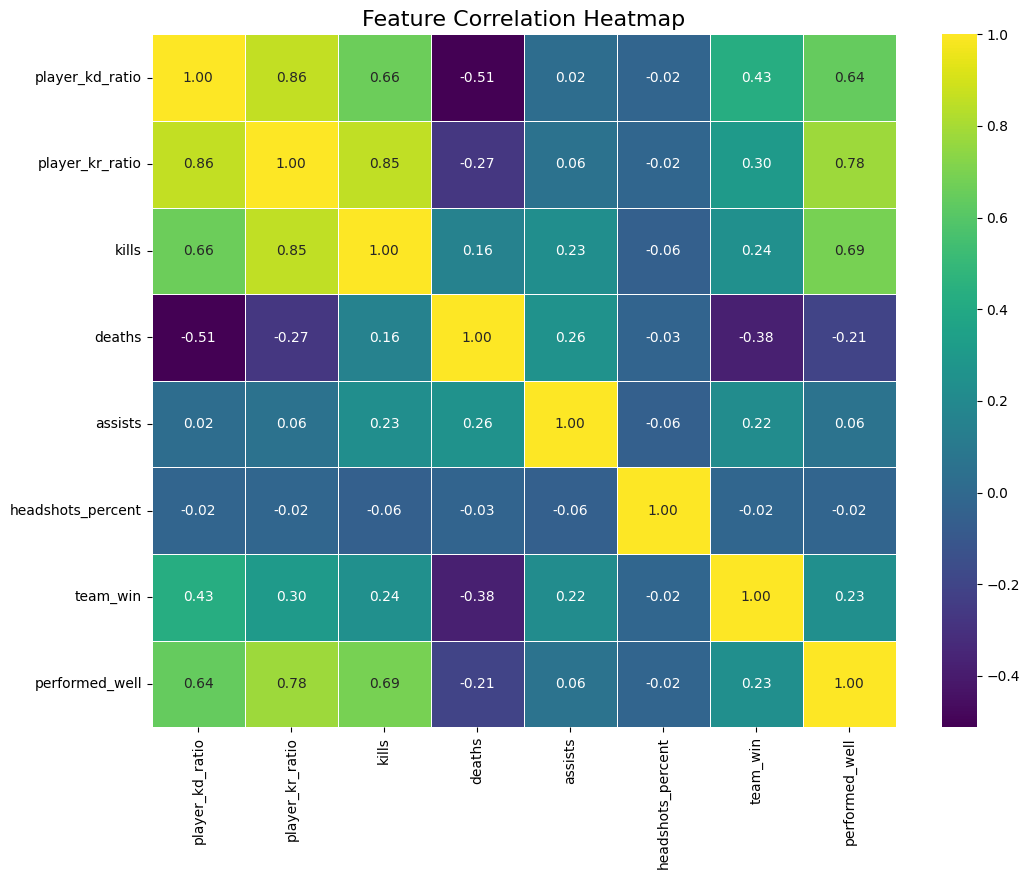


Correlation of features with 'performed_well':
player_kd_ratio      0.640874
player_kr_ratio      0.778315
kills                0.687565
deaths              -0.207616
assists              0.061716
headshots_percent   -0.022724
team_win             0.234387
performed_well       1.000000
Name: performed_well, dtype: float64


In [3]:
# Calculate the correlation matrix for all numeric columns
corr_matrix = df.corr(numeric_only=True)

# Create a heatmap for a visual representation of correlations
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

# For a more direct answer, display the correlations with 'performed_well'
# and sort them to see the strongest relationships.
print("\nCorrelation of features with 'performed_well':")
print(corr_matrix['performed_well'])

In [4]:
from sklearn.metrics import accuracy_score

# --- Baseline Model ---
# Logic: Predict "Good" (1) if historical avg K/R > 0.7

# First, sort the DataFrame chronologically (oldest matches first)
# The API returns the most recent matches first, so we reverse the index.
df_sorted = df.iloc[::-1].reset_index(drop=True)

# Calculate the rolling average of the last 30 matches' K/R ratio.
# shift(1) is crucial: it ensures we only use *past* matches to predict the current one.
df_sorted['historical_avg_kr'] = df_sorted['player_kr_ratio'].shift(1).rolling(window=30, min_periods=1).mean()

# We can't make predictions for matches where we don't have historical data, so drop them.
df_baseline = df_sorted.dropna(subset=['historical_avg_kr']).copy()

# Apply the baseline logic to make predictions
df_baseline['baseline_prediction'] = (df_baseline['historical_avg_kr'] > 0.7).astype(int)

# --- Measure Performance ---
# 'performed_well' is the actual result (the ground truth).
# 'baseline_prediction' is our simple model's guess.
y_true = df_baseline['performed_well']
y_pred = df_baseline['baseline_prediction']

# Calculate and print the accuracy score
baseline_accuracy = accuracy_score(y_true, y_pred)

print("--- Baseline Model Results ---")
print(f"Deliverable: The score to beat for our future ML models.")
print(f"Baseline Model Accuracy: {baseline_accuracy:.2%}")

--- Baseline Model Results ---
Deliverable: The score to beat for our future ML models.
Baseline Model Accuracy: 44.91%


Creating player-specific historical features...
Adding map features using one-hot encoding...
Dataset size after all feature engineering: 3778

Features for model now include player history, map, and team/opponent context.
Total features: 14

Training set size: 3022 samples
Testing set size: 756 samples
[LightGBM] [Info] Number of positive: 1449, number of negative: 1573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1704
[LightGBM] [Info] Number of data points in the train set: 3022, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479484 -> initscore=-0.082111
[LightGBM] [Info] Start training from score -0.082111

LightGBM model training complete.

Baseline Accuracy: 45.84%
LightGBM Accuracy with Full Context: 71.96%

Success! The new model outperforms the baseline.

Classification Report:
                  precis

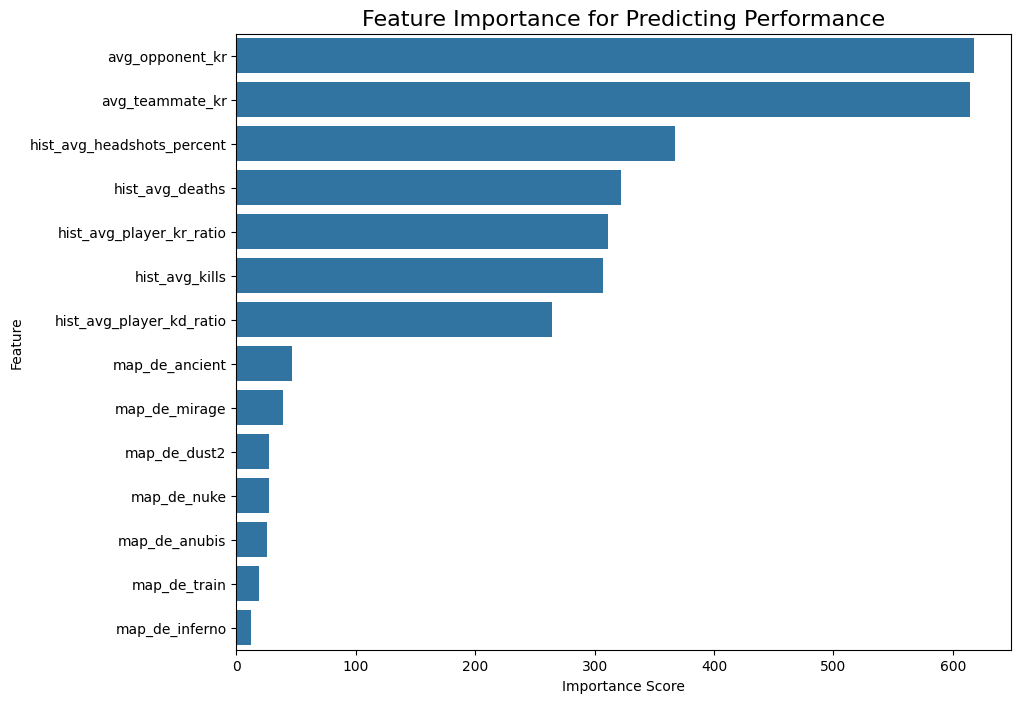

In [5]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load and Prepare the Data ---
# Load the new dataset with team/opponent context
df = pd.read_csv('../data/faceit_match_data_v2.csv')
df_sorted = df.sort_values(by='match_id').reset_index(drop=True)

# --- 2. Feature Engineering ---
# We still need to create the historical performance features for each player
window_size = 30
features_to_average = ['player_kr_ratio', 'player_kd_ratio', 'kills', 'deaths', 'headshots_percent']

print("Creating player-specific historical features...")
for feature in features_to_average:
    new_feature_name = f'hist_avg_{feature}'
    df_sorted[new_feature_name] = df_sorted.groupby('player_id')[feature].shift(1).rolling(window=window_size, min_periods=1).mean()

# Drop rows where we couldn't create historical features
df_model_base = df_sorted.dropna(subset=[f'hist_avg_{f}' for f in features_to_average]).copy()

# One-hot encode the 'map' column
print("Adding map features using one-hot encoding...")
map_dummies = pd.get_dummies(df_model_base['map'], prefix='map')
df_model = pd.concat([df_model_base, map_dummies], axis=1)

print(f"Dataset size after all feature engineering: {len(df_model)}")

# --- 3. Define Features (X) and Target (y) ---
historical_features = [f'hist_avg_{f}' for f in features_to_average]
map_features = list(map_dummies.columns)
# ADDED: Include the new team and opponent context features
context_features = ['avg_teammate_kr', 'avg_opponent_kr']

features_for_model = historical_features + map_features + context_features
X = df_model[features_for_model]
y = df_model['performed_well']

print("\nFeatures for model now include player history, map, and team/opponent context.")
print(f"Total features: {len(features_for_model)}")

# --- 4. Split Data into Training and Testing Sets (Time-Based) ---
split_index = int(len(df_model) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# --- 5. Train the LightGBM Model ---
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_train, y_train)
print("\nLightGBM model training complete.")

# --- 6. Evaluate the New Model ---
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nBaseline Accuracy: 45.84%") 
print(f"LightGBM Accuracy with Full Context: {accuracy:.2%}")

if accuracy > 0.4584:
    print("\nSuccess! The new model outperforms the baseline.")
else:
    print("\nThe new model does not outperform the baseline.")

# --- 7. Deeper Evaluation & Feature Importance ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bad Performance', 'Good Performance']))

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Feature Importances ---")
print(feature_importance_df.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Feature Importance for Predicting Performance', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


In [6]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import pandas as pd

# This code assumes X_train and y_train have been created in the previous cells

# --- 1. Define the Hyperparameter Grid ---
# We define a dictionary with the settings we want to test.
# GridSearchCV will try every possible combination.
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
}

# --- 2. Set up the Grid Search ---
# Initialize a new LightGBM model
estimator = lgb.LGBMClassifier(random_state=42)

# Set up the GridSearchCV object
# cv=3 means it will use 3-fold cross-validation
# n_jobs=-1 uses all available CPU cores to speed up the process
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2  # This will print progress updates
)

# --- 3. Run the Grid Search ---
print("Starting Grid Search for optimal hyperparameters...")
grid_search.fit(X_train, y_train)
print("\nGrid Search Complete.")

# --- 4. Display the Best Results ---
print(f"\nBest Hyperparameters Found: {grid_search.best_params_}")
print(f"Best Accuracy during Cross-Validation: {grid_search.best_score_:.2%}")


Starting Grid Search for optimal hyperparameters...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Number of positive: 966, number of negative: 1049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of positive: 966, number of negative: 1048
[LightGBM] [Info] Number of data points in the train set: 2015, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479404 -> initscore=-0.082429
[LightGBM] [Info] Number of positive: 966, number of negative: 1049
[LightGBM] [Info] Start training from score -0.082429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of positive: 966, number of negative: 10

In [7]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# --- 1. Get the Best Model ---
# The grid_search object already contains the best model found during the search
final_model = grid_search.best_estimator_

print("Using the best model found during Grid Search to make final predictions.")

# --- 2. Evaluate the Final Model on the Test Set ---
# Use the best model to make predictions on our unseen test data
y_pred_final = final_model.predict(X_test)

# Calculate the final accuracy
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f"\nPrevious Best Accuracy (Default Settings): 71.96%")
print(f"Final Tuned Model Accuracy: {final_accuracy:.2%}")

if final_accuracy > 0.7196:
    print("\nSuccess! Hyperparameter tuning improved the model's performance.")
else:
    print("\nHyperparameter tuning did not improve the model's performance over the defaults.")

# --- 3. Final Classification Report ---
# This report shows the performance of our best and final model
print("\nFinal Model Classification Report:")
report_final = classification_report(y_test, y_pred_final, target_names=['Bad Performance', 'Good Performance'])
print(report_final)

# --- 4. Final Feature Importance ---
# Let's see what the most important features were for our best model
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Final Model Top 10 Feature Importances ---")
print(feature_importance_df.head(10))



Using the best model found during Grid Search to make final predictions.

Previous Best Accuracy (Default Settings): 71.96%
Final Tuned Model Accuracy: 73.41%

Success! Hyperparameter tuning improved the model's performance.

Final Model Classification Report:
                  precision    recall  f1-score   support

 Bad Performance       0.74      0.78      0.76       406
Good Performance       0.73      0.69      0.70       350

        accuracy                           0.73       756
       macro avg       0.73      0.73      0.73       756
    weighted avg       0.73      0.73      0.73       756


--- Final Model Top 10 Feature Importances ---
                       Feature  Importance
12             avg_teammate_kr         514
13             avg_opponent_kr         466
3              hist_avg_deaths         186
4   hist_avg_headshots_percent         185
2               hist_avg_kills         179
1     hist_avg_player_kd_ratio         126
0     hist_avg_player_kr_ratio         